#Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
# !git clone https://github.com/ziadloo/attention_keras.git

#Import Attention Layer
- From the github file, we will import AttentionLayer.

In [3]:
import os
import sys
base_dir = os.path.join(os.getcwd(), "drive/MyDrive/Colab Notebooks/natural language processing/Text Summarization/attention_keras")
sys.path.insert(0, base_dir)

from tensorflow.keras import Input, layers, models
from layers.attention import AttentionLayer

attn_layer = AttentionLayer(name='attention_layer')

#Get the data
- The dataset will be the reviews of fine foods from Amozon. This is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews)

In [4]:
#Dataset consist of more than 500000 reviews. So, this is the huge dataset. To reduce computation power, we will deal with 100000 reviews.

data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/natural language processing/Text Summarization/amazon review dataset/Reviews.csv",nrows=100000)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


#Data Preprocessing


In [5]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [7]:
#Some words will be in its short form, which will not be recognized by algorithm. 
#We will now replace these words by their exact form

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
#Preprocess the data

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()  # Convert everything to lowercase
    newString = BeautifulSoup(newString, "lxml").text   #Remove HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)  
    newString = re.sub('"','', newString) 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #Contraction mapping   
    newString = re.sub(r"'s\b","",newString)  
    newString = re.sub("[^a-zA-Z]", " ", newString)  # remove all character except latters
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]  
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
#Clean the text column of dataframe 

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [11]:
#Clean the summary column of dataframe

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [13]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [14]:
#make a column of cleaned text and summary in dataframe

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [15]:
#drop empty(na) rows


data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

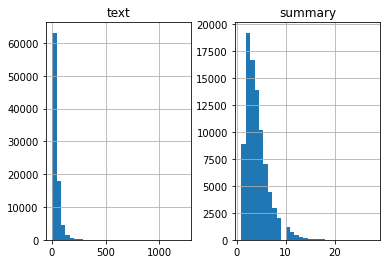

In [16]:
#count maximum length of text and summary in dattaframe

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Since majority of text have maximum length 10 and majority of text have maximum length 30, we will fix these values as max length parameters

In [17]:
max_text_len=30
max_summary_len=8

In [18]:

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands
...,...,...
47165,stuff awesome best flavor boil water drain water add spice packet add hot water,great stuff
47166,love noodle little spicy wife perfct,good stuff
47167,love buy another box done last one,yummy
47168,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,great ramen


- Add **START** and *END* token as **sos(start of sentence)** and **eos(end of sentence)** respectively

In [19]:

df['summary'] = df['summary'].apply(lambda x : 'sos '+ x + ' eos')

In [20]:
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sos good quality dog food eos
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sos not as advertised eos
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sos cough medicine eos
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sos great taffy eos
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sos great just as good as the expensive brands eos
...,...,...
47165,stuff awesome best flavor boil water drain water add spice packet add hot water,sos great stuff eos
47166,love noodle little spicy wife perfct,sos good stuff eos
47167,love buy another box done last one,sos yummy eos
47168,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,sos great ramen eos


In [74]:
#Preprocess the data

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num =0,max_text_len=30):
    newString = text.lower()  # Convert everything to lowercase
    newString = BeautifulSoup(newString, "lxml").text   #Remove HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)  
    newString = re.sub('"','', newString) 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #Contraction mapping   
    newString = re.sub(r"'s\b","",newString)  
    newString = re.sub("[^a-zA-Z]", " ", newString)  # remove all character except latters
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]  
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)  
    cleaned_text = (" ".join(long_words)).strip() 

   
    cleaned_text = pd.DataFrame([cleaned_text])
    cleaned_text[0] = cleaned_text[0].apply(lambda x : 'sos '+ x + ' eos')
    x_test_seq = x_tokenizer.texts_to_sequences(cleaned_text[0])
    
    return pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')


In [75]:
tex = 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo"'

In [78]:
t =text_cleaner(tex,num =0,max_text_len=30)
t

array([[   5,  115, 2235, 3270, 1219,  723,  723,  195,  108, 1027, 2818,
         144, 3094, 1041, 2486, 8294,    5, 3270,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

#Split the data into train and test

In [21]:
from sklearn.model_selection import train_test_split

#use 10% data for testing
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

#Tokenization of text

In [22]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [50]:
import pickle

with open('tokenizer.pkl', 'wb') as fout:
    pickle.dump(x_tokenizer, fout)

In [25]:
x_voc

8440

#Tokenization of Summary 

In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


In [28]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [29]:
y_tokenizer.word_counts['sos'],len(y_tr)

(42453, 42453)

In [30]:
#deleting the rows that contain only START and END tokens

ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

#Model Building

In [32]:

from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer({"values": encoder_outputs,"query": decoder_outputs})

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer({"values": encoder_outputs,"query": decoder_outputs})

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
#using sparse categorical cross-entropy as the loss function

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
#usinf Earlystop to get the control over training and validation loss

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [36]:
#Training the model

history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], 
                                   y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
324/324 [==============================] - 871s 3s/step - loss: 3.1663 - val_loss: 2.5805
Epoch 2/50
324/324 [==============================] - 858s 3s/step - loss: 2.5515 - val_loss: 2.5291
Epoch 3/50
324/324 [==============================] - 858s 3s/step - loss: 2.3880 - val_loss: 2.3298
Epoch 4/50
324/324 [==============================] - 897s 3s/step - loss: 2.2628 - val_loss: 2.2677
Epoch 5/50
324/324 [==============================] - 873s 3s/step - loss: 2.1790 - val_loss: 2.2157
Epoch 6/50
324/324 [==============================] - 867s 3s/step - loss: 2.1249 - val_loss: 2.1706
Epoch 7/50
324/324 [==============================] - 847s 3s/step - loss: 2.0628 - val_loss: 2.1429
Epoch 8/50
324/324 [==============================] - 839s 3s/step - loss: 2.0179 - val_loss: 2.1242
Epoch 9/50
324/324 [==============================] - 857s 3s/step - loss: 1.9743 - val_loss: 2.0986
Epoch 10/50
324/324 [==============================] - 839s 3s/step - loss: 1.9239 - val_lo

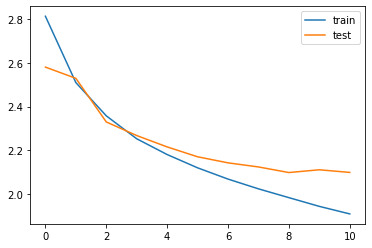

In [37]:
#Understand the behavior of the model

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
model.save('Summarization_model.h5')

In [39]:
#Buiöd the dictionary to convert the index into word for traget and source vocabulary

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

#Inference

In [88]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [89]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

In [90]:
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [91]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer({"values":decoder_hidden_state_input, "query": decoder_outputs2})
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [92]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 


In [93]:
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [94]:
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [95]:
#function for the implementation of the inference process

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [96]:
#convert an integer sequence to a word sequence for summary as well as the reviews

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString


def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [97]:
#few summaries generated by the model

for i in range(9,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")


Review: dog loves tiny treats keep one car one house 
Original summary: dog loves them 
Predicted summary:  my dog loves these


Review: liked coffee much subscribing dark rich smooth 
Original summary: makes great cup of java 
Predicted summary:  good coffee


Review: far dog tried chicken peanut butter flavor absolutely loves love natural makes happy giving dog something healthy treats small soft big plus calories 
Original summary: love zuke mini naturals 
Predicted summary:  my dog loves these


Review: absolutely delicious satisfy something sweet really filling great early morning time make breakfast great afternoon snack work feeling sluggish 
Original summary: protein bar 
Predicted summary:  great snack


Review: aware decaf coffee although showed search decaf cups intended purchase gift kept recipient drink caffeine favorite means 
Original summary: not decaf 
Predicted summary:  not as good as decaf


Review: wonderful wrote perfect iced cookie one pen writing cookies names h

In [80]:
#Install flask-ngrok

!pip install flask-ngrok

In [81]:
def text_cleaner(text,num =0,max_text_len=30):
    newString = text.lower()  # Convert everything to lowercase
    newString = BeautifulSoup(newString, "lxml").text   #Remove HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)  
    newString = re.sub('"','', newString) 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #Contraction mapping   
    newString = re.sub(r"'s\b","",newString)  
    newString = re.sub("[^a-zA-Z]", " ", newString)  # remove all character except latters
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]  
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)  
    cleaned_text = (" ".join(long_words)).strip() 

   
    cleaned_text = pd.DataFrame([cleaned_text])
    cleaned_text[0] = cleaned_text[0].apply(lambda x : 'sos '+ x + ' eos')
    x_test_seq = x_tokenizer.texts_to_sequences(cleaned_text[0])
    
    return pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')




In [103]:
#create flask app

import numpy as np
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template,request

#Copy the path of templates and static folders
#Paste those paths in the respective parameters like (...., template_folder= ..,static_folder=...)

app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/natural language processing/Text Summarization/templates', static_folder='/content/drive/MyDrive/Colab Notebooks/natural language processing/Text Summarization/static')

run_with_ngrok(app)

@app.route('/')
def home():
    return render_template('home.html')

@app.route('/predict',methods=['POST'])
def predict():
    '''
    For rendering results on HTML GUI
    '''
    int_features = [str(x) for x in request.form.values()]
    text_seq =text_cleaner(int_features[0],num =0,max_text_len=30)
    summary = decode_sequence(text_seq.reshape(1,max_text_len))
    
    return render_template('home.html', data='Summary of text :{} '.format(summary))

if __name__ == '__main__':

  app.run()
  app.debug = True

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c9079fa37fd4.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [07/May/2021 22:32:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/May/2021 22:32:35] "GET /static/styles/style.css HTTP/1.1" 200 -
127.0.0.1 - - [07/May/2021 22:32:35] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [07/May/2021 22:34:01] "POST /predict HTTP/1.1" 200 -
